# Ontario General Election Analysis

---

## Motivation

We wanted to analyze the results of the 2018 Ontario general election. In particular we were interested in the role that financial donations play in predicting success in elections on a per-district level. By examining data sources that were available from Elections Ontario, it seemed that it would be possible to determine relationships between the success of candidates and parties running for election, and the financial donations that they recieved in the lead-up to the election. 


---

## Table of Contents

1. Gathering Data
1. Preparing Data
1. Initial Analysis
1. Linear Regressions
1. Machine Learning Predictions
1. Conclusions


In [1]:
# - Try to combine some old/new districts
# - Density categories
# - Predict 2022

In [2]:
# Topic: Financial contributions and election results in Ontario General Elections

# Data Set: Various combined from Elections Ontario website

# Question: Data about financial contributions and election results obtained from the Elections Ontario website and combined
# in order to determine the effect that financial contributions have towards elections results in the various electoral districts,
# depending on the party that recieves the contributions and other factors.

%matplotlib inline
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import pylab 
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import requests
import json
import csv
from typing import List


import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)


# First we read the csv files into data frames.


df2014 = pd.read_csv('2014_Filed_Statement_Contributions.csv')
df2015 = pd.read_csv('2015_Filed_Statement_Contributions.csv')
df2016 = pd.read_csv('2016_Filed_Statement_Contributions.csv')
df2017 = pd.read_csv('2017_Filed_Statement_Contributions.csv')
df2018 = pd.read_csv('2018_Filed_Statement_Contributions.csv')
df2019 = pd.read_csv('2019_Filed_Statement_Contributions.csv')
df2020 = pd.read_csv('2020_Filed_Statement_Contributions.csv')
df2021 = pd.read_csv('2021_Filed_Statement_Contributions.csv')

dfresults2011 = pd.read_csv('Explorer_All_15072022_214115.csv')
dfresults2014 = pd.read_csv('Explorer_All_15072022_214028.csv')
dfresults2018 = pd.read_csv('Explorer_All_15072022_192010.csv')


# Here we had to change the abbreviations because they weren't consistent throughout the years


map2011 = {'PC':'PCP','ND':'NDP','L':'LIB','GP':'GPO'}
map2014 = {'OLP':'LIB'}

dfresults2011['Party']=dfresults2011['Party'].replace(map2011)
dfresults2014['Party']=dfresults2014['Party'].replace(map2014)


# Now we combine all the data frames into two larger ones.


dffinance = pd.concat([df2014,df2015,df2016,df2017,df2018])
dfresults = pd.concat([dfresults2011,dfresults2014,dfresults2018])

# Formating Amount, creating a new, consistent District attribute, and creating an attribute that notes if that district/party
# combination won the district.

dffinance['Party']=dffinance['Party Abbreviation']
dffinance['District'] = dffinance['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dfresults['District'] = dfresults['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dffinance['Amount'] = dffinance['Amount'].replace('[\$,]', '', regex=True).astype(float)
def wincheck(num):
    if num ==0:
        return 0
    else:
        return 1
dfresults['Winner']= dfresults['Plurality'].map(wincheck)

finance = dffinance[['District','Party','Amount']]
finance = finance.fillna('0')
finance.sort_values(by='District')
finance.groupby(['District']).sum()

results = dfresults[['District','Year','Party','Votes Cast','Winner']]

# Combining everything into one data frame where each row is one district/party combination

mainresults = results.loc[results['Party'].isin(['LIB','PCP','NDP','GPO'])]
mainfinance = finance.loc[finance['Party'].isin(['LIB','PCP','NDP','GPO'])]

mainresults2018 = mainresults.loc[mainresults['Year'] == 2018]
mainresults2014 = mainresults.loc[mainresults['Year'] == 2014]
mainresults2011 = mainresults.loc[mainresults['Year'] == 2011]
mainresults2014 = mainresults2014.rename(columns = {'Votes Cast':'Votes Cast 2014','Winner':'Winner 2014'})
mainresults2011 = mainresults2011.rename(columns = {'Votes Cast':'Votes Cast 2011','Winner':'Winner 2011'})

groupresults=mainresults2018.groupby(['District','Party']).sum()

groupedyears = pd.merge(mainresults2014,mainresults2011,on=['District','Party'], how = 'outer')

groupfinance=mainfinance.groupby(['District','Party']).sum()

complete=pd.merge(groupresults,groupfinance,on=['District','Party'], how = 'inner')

complete = pd.merge(complete,groupedyears,on=['District','Party']).drop(columns=['Year','Year_x','Year_y'])


# Adding a Vote % attribute, indicating what percentage of the total votes wen to that party, and an attribute for if the entry
# won the 2022 election - full data was not available for 2022 but it will be used later.


complete['Vote %'] = complete['Votes Cast']/complete.groupby('District')['Votes Cast'].transform('sum')

dfwinners2022 = pd.read_csv('Winning parties 2022.csv')
winners2022map = {'Progressive Conservative':'PCP','New Democratic':'NDP','Liberal':'LIB','Green':'GPO'}
dfwinners2022['Party']=dfwinners2022['Party'].replace(winners2022map)
dfwinners2022['District'] = dfwinners2022['District'].str.replace('—', ' ').str.replace('--', ' ')
dfwinners2022['Winner 2022']=1

complete = pd.merge(complete,dfwinners2022, left_on = ['District','Party'], right_on = ['District','Party'], how = 'outer').dropna(subset = ['Votes Cast']).fillna(0)


# Created a new data frame for the entire party and their financial contributions, and renamed attributes so there is now
# a District Donation attribute corresponding to the donations recieved by the candidate in that district, as well as a 
# Total Party Donation attribute corresponding to the total donations received by the party in the entire province.


completegroups = complete.groupby('Party').sum()

for party in ['GPO','LIB','NDP','PCP']:
    
    completegroups.loc[party,'Amount'] = finance.groupby('Party').sum().loc[party,'Amount']

complete['Total Party Donations'] = complete['Party'].map(dict(completegroups['Amount']))

complete = complete.rename(columns={'Amount':'District Donations'})
completegroups = completegroups.rename(columns={'Amount':'Total Party Donations'})

complete['District Donations'] = complete['District Donations'].fillna(0)

# The code to scrape the web for the population and area data

# -*- coding: utf-8 -*-


import requests
import pandas as pd
import json
import csv
from typing import List

#creating list element
info_list=[[]]

for dist in range(124):
    #change url to another district with evey new loop
    url='https://voterinformationservice.elections.on.ca/api/electoral-district/en/'+str(dist+1)
    
    #grab url
    html_text=requests.get(url).text    
    
    #load json data
    data=json.loads(html_text)    
    
    #Gather multiple json elements to one
    info_gather=[]
    info_gather.append(data['id'])
    info_gather.append(data['areaSquareKm'])
    info_gather.append(data['population'])
    info_gather.append(data['mppName'])
    info_gather.append(data['name'])    
    
    
    #append data to list
    info_list.append(info_gather)
    
#Create Pandas Dataframe
df=pd.DataFrame(info_list[1:],columns=['District #','Area','Population','mppName','District'])

#Save df to CSV file
df.to_csv('population area 2.csv',encoding='utf-8',index=False)


# Created attributes based on the population, area, and population density of each electoral district, as well as an attribute 
# Voter Turnout that is the percentage of the population that voted.

dfpoparea = pd.read_csv('population area 2.csv')
dfpoparea['District'] = dfpoparea['District'].str.replace('—', ' ').str.replace('--', ' ')
nums = dfresults['Electoral District'].str.extract(r'([0-9]{3,})')
words = dfresults['Electoral District'].str[6:].astype(dtype='string').str.replace('—', ' ').str.replace('--', ' ')
dictdistrict = dict(zip(nums[0],words))

complete['District'] = complete['District'].astype('string')
complete['Area'] = complete['District'].map(dict(dfpoparea[['District', 'Area']].values))
complete['Population'] = complete['District'].map(dict(dfpoparea[['District', 'Population']].values))
complete['Density'] = complete['Population']/complete['Area']
complete['Voter Turnout'] = complete['District'].map(dict(complete.groupby('District').sum()['Votes Cast']))/complete['Population']

# Created a new data frame that is able to compare the donations made by each party in each of the districts.


gpodonations = complete.loc[complete['Party']=='GPO'][['District','District Donations']].rename(columns = {'District Donations':'GPO Donations'})
libdonations = complete.loc[complete['Party']=='LIB'][['District','District Donations']].rename(columns = {'District Donations':'LIB Donations'})
ndpdonations = complete.loc[complete['Party']=='NDP'][['District','District Donations']].rename(columns = {'District Donations':'NDP Donations'})
pcpdonations = complete.loc[complete['Party']=='PCP'][['District','District Donations']].rename(columns = {'District Donations':'PCP Donations'})

partydonations = gpodonations.merge(libdonations, how = 'outer', on = 'District').merge(ndpdonations, how = 'outer', on = 'District').merge(pcpdonations, how = 'outer', on = 'District')

# The palette below is made for the graphs.

partypalette = {'LIB':'red', 'PCP':'blue', 'GPO':'green', 'NDP':'orange'}

##############################################################################################################
# Finally we have useful data frames we can do some analysis with.
##############################################################################################################

---

## Gathering Data

The data that we were interested in analyzing were data related to the results of the 2018 Ontario general election. We were especially interested in finding data related to the financial contributions towards the political parties involved in the election and to the candidates running in different electoral districts. We were also interested in other data related to the electoral districts. The data for the financial contributions from the years 2014-2018 were used, because those were the years leading up to the 2018 election, and seemed the most applicable donations towards that particular election. The financial contribution data was downloaded from the Elections Ontario website in the form of a .csv file[^1]. The results of the general elections in 2011, 2014 and 2018, were similarly retrieved from the Elections Ontario website[^2]. Data for the population and area were scraped from the Elections Ontario website[^3] since it was not available for download and the information on the page for each district needed to be combined. The results for the 2022 election were not available, and were instead retrieved from Wikipedia[^4].

[^1]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://results.elections.on.ca/en/data-explorer?fromYear=1867&amp;toYear=2022&amp;electionId=504&amp;levelOfDetail=candidate  
[^2]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://finances.elections.on.ca/en/contributions?fromYear=2014&amp;toYear=2022 
[^3]: Elections Ontario. (n.d.). Retrieved August 14, 2022, from https://voterinformationservice.elections.on.ca/en/electoral-district/1 
[^4]: Wikimedia Foundation. (2022, July 27). 2022 Ontario general election. Wikipedia. Retrieved August 14, 2022, from https://en.wikipedia.org/wiki/2022_Ontario_general_election 

---

## Preparing Data

After the data were obtained, we needed to prepare data frames for analysis, making sure that in each data frame the data is tidy, so that each row is one observation, and each column is one variable with one value. 

#### Challenges

One significant difficulty that occured was due to the change of the Ontario electoral districts in 2018. The 107 districts that existed in the 2011 and 2014 elections were increased by 17 to 124, and many of the districts had their boundaries redrawn. This presented a significant hurdle since donations to many districts in the years leading up to the election could not be mapped directly onto the districts that existed during the election. It was decided to only use the districts that did not change. Fortunately, 76 of the original 107 districts remained the same and represent a significant sample.

Another issue is that many of the donation entries were not to a particular candidate in an electoral district, and were instead to the provincial party. Since these donations represented a majority of the money donated during the 2014-2018 period examined, they needed to be accounted for. 

lastly, the existence of a large number of political parties that won no ridings, and received very little or no financial donations threatened to make the analysis unecessarily messy, so the decision was made to only include parties that won at least one riding, so the Liberal, Progressive Conservative, Green, and New Democratic parties were the only ones used.

#### New Attributes

While there were many attributes included in the data downloaded, several others were created to help in the analysis. First, the total donations that were recieved by the party were calculated and added to each candidate. The population density in people per square kilometer was calculated and included, as well as the percentage of the population that turned out to vote. test


<div style="page-break-after: always;"></div>


In [3]:
# completegroups.head(5)

In [4]:
# partydonations.head(5)

In [5]:
# complete.head(5)

---

## Initial Analysis

The first thing we can look at is the relationship between the amount of money that each party recieved from 2014-2018 and their relative performance in the 2018 elections, and while we can see a relationship between donations and election performance, we can see again that the Liberals did relatively poorly.

At first we can compare how each party did in the 2018 election relative to the 2014 election, and it is clear that the biggest change is that the Liberals did much worse in 2018, despite still recieving a significant number of donations. 

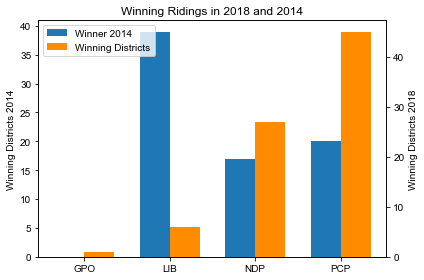

In [6]:
labels = list(completegroups.index)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots()
ax.set_xticks(x, labels)
ax2 = ax.twinx()

ax.bar(x - width/2, completegroups['Winner 2014'], width, label='Winner 2014')
ax2.bar(x + width/2, completegroups['Winner'], width, label='Winning Districts', color = 'darkorange')

ax.set_ylabel('Winning Districts 2014')

ax2.set_ylabel('Winning Districts 2018')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

sns.set_style("white")
plt.title('Winning Ridings in 2018 and 2014')
plt.tight_layout()
# plt.savefig('winner bar graph.png')   
plt.show()

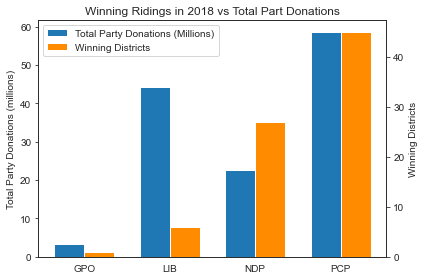

In [7]:
labels = list(completegroups.index)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots()
ax.set_xticks(x, labels)
ax2 = ax.twinx()

ax.bar(x - width/2, completegroups['Total Party Donations']/1000000, width, label='Total Party Donations (Millions)')
ax2.bar(x + width/2, completegroups['Winner'], width, label='Winning Districts', color = 'darkorange')

ax.set_ylabel('Total Party Donations (millions)')

ax2.set_ylabel('Winning Districts')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

sns.set_style("white")
plt.title('Winning Ridings in 2018 vs Total Part Donations')
plt.tight_layout()
# plt.savefig('winner total bar graph.png')   
plt.show()

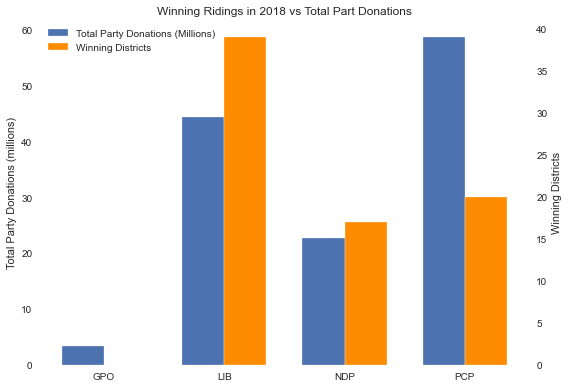

In [45]:
labels = list(completegroups.index)
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots()
ax.set_xticks(x, labels)
ax2 = ax.twinx()

ax.bar(x - width/2, completegroups['Total Party Donations']/1000000, width, label='Total Party Donations (Millions)')
ax2.bar(x + width/2, completegroups['Winner 2014'], width, label='Winning Districts', color = 'darkorange')

ax.set_ylabel('Total Party Donations (millions)')

ax2.set_ylabel('Winning Districts')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

sns.set_style("white")
plt.title('Winning Ridings in 2018 vs Total Part Donations')
plt.tight_layout()
# plt.savefig('winner total bar graph.png')   
plt.show()

The next thing is to address the main question we are attempting to answer, what effect do donations have on election results? We can start with a graph of the relationship between the District Donations and the Votes Cast. Do donations to a district's candidate results in more votes for that candidate? If so we would expect to see a positive correlation between the two variables. Examining the plot reveals what appears to be a positive relationship between the two variables, which suggests that donations are correlated to the number of votes cast. It can also be seen that the relationship is not evenly spread out among the parties. The two smaller parties, the Green party and the NDP, seem to have the strongest relationship, with the Liberals having the weakest. This will be examined further in the Linear Regressions section. 

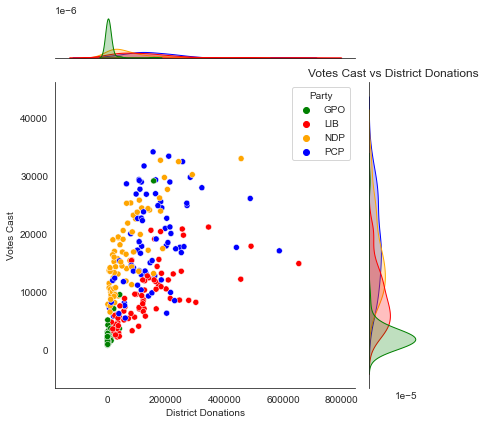

In [8]:
sns.jointplot(data = complete, x = 'District Donations', y = 'Votes Cast', hue = 'Party', palette = partypalette)

sns.set_style("whitegrid")
plt.title('Votes Cast vs District Donations')
plt.tight_layout()
# plt.savefig('votes and district donations.png')
plt.show()

The next thing we can look at is a comparison of the distributions of donations in the different districts, seperated by whether the district won or not. We can see above that candidates that recieved more donations tended to recieve more votes, but did winning candidates for each party tend to recieve more donations? Below we can violin plots that show the distribution of donations in winning and losing districts for each party. We can see that for every party, the winning districts did tend to recieve more donations. We can also see that for the Green party, the Conservative party, and the NDP, the outlier districts with very higher donations were largely in the winning districts, whereas the Liberals had losing districts with very high donation amounts. 

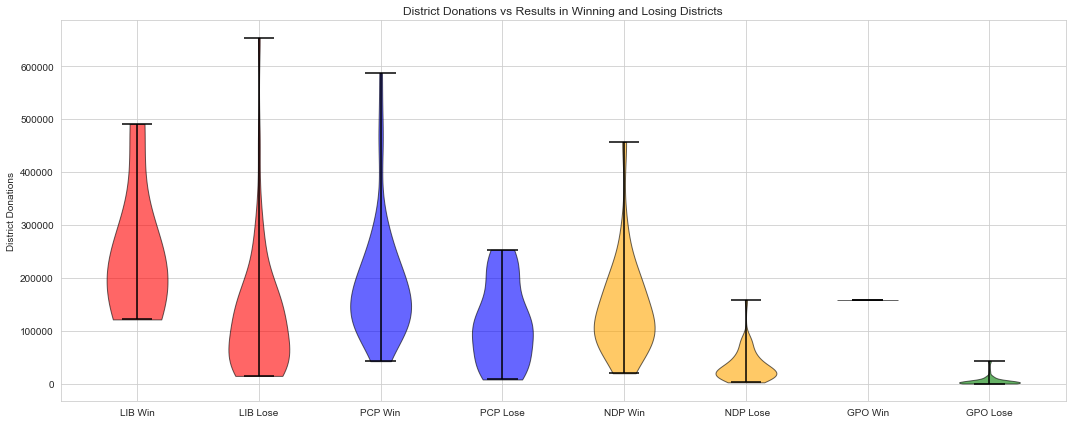

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

LIBwin=complete.groupby('Party').get_group('LIB').loc[complete.groupby('Party').get_group('LIB')['Winner']==1]['District Donations']
LIBlose=complete.groupby('Party').get_group('LIB').loc[complete.groupby('Party').get_group('LIB')['Winner']==0]['District Donations']

PCPwin=complete.groupby('Party').get_group('PCP').loc[complete.groupby('Party').get_group('PCP')['Winner']==1]['District Donations']
PCPlose=complete.groupby('Party').get_group('PCP').loc[complete.groupby('Party').get_group('PCP')['Winner']==0]['District Donations']

GPOwin=complete.groupby('Party').get_group('GPO').loc[complete.groupby('Party').get_group('GPO')['Winner']==1]['District Donations']
GPOlose=complete.groupby('Party').get_group('GPO').loc[complete.groupby('Party').get_group('GPO')['Winner']==0]['District Donations']

NDPwin=complete.groupby('Party').get_group('NDP').loc[complete.groupby('Party').get_group('NDP')['Winner']==1]['District Donations']
NDPlose=complete.groupby('Party').get_group('NDP').loc[complete.groupby('Party').get_group('NDP')['Winner']==0]['District Donations']


p = axs.violinplot([LIBwin,LIBlose,PCPwin,PCPlose,NDPwin,NDPlose,GPOwin,GPOlose])
p['cmaxes'].set_color('black')
p['cmins'].set_color('black')
p['cbars'].set_color('black')

colors = ['red','red','blue','blue','orange','orange','green','green']
for pc in p['bodies']:
    pc.set_edgecolor('black')
    pc.set_alpha(0.6)

for i in range(8):
    
    p['bodies'][i].set_facecolor(colors[i])
    
axs.set_title('District Donations vs Results in Winning and Losing Districts')


axs.yaxis.grid(True)
axs.set_xticks([y + 1 for y in range(8)], labels=['LIB Win','LIB Lose','PCP Win','PCP Lose','NDP Win',' NDP Lose','GPO Win','GPO Lose'])    
axs.set_ylabel('District Donations')    

sns.set_style("whitegrid")
plt.tight_layout()
# plt.savefig('violin plot.png')   
plt.show()

We can now produce a plot of the donations to each party, in each district, to see if there is any clustering. It could be possible that districts that recieve more donations from one party tend to recieve more from the others. However, there does not appear to be this sort of relationship, and the correlation between the donations to different parties in the same districts are very low.

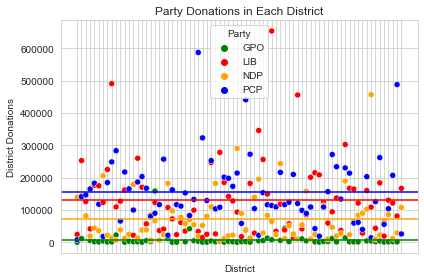

In [10]:
g = sns.scatterplot(data = complete, x = 'District', y = 'District Donations', hue = 'Party', palette = partypalette)

g.axhline(complete.loc[complete['Party']=='GPO']['District Donations'].mean(), c = 'green')
g.axhline(complete.loc[complete['Party']=='LIB']['District Donations'].mean(), c = 'red')
g.axhline(complete.loc[complete['Party']=='NDP']['District Donations'].mean(), c = 'orange')
g.axhline(complete.loc[complete['Party']=='PCP']['District Donations'].mean(), c = 'blue')
g.tick_params(left=False, bottom=False)
g.set(xticklabels=[])



sns.set_style("whitegrid")
plt.title('Party Donations in Each District')
plt.tight_layout()
# plt.savefig('district donations spread.png') 
plt.show()


We can also look at the donations per district, sorted in descending order, and similarly, a histogram of the number of districts within certain bins of donations. This gives us an idea about how the donations are distributed to the districts for each party. It is clear that there is a clear difference between the parties in terms of how wealthy they are. The Conservative party recieves the most money, followed by the Liberals, the NDP and the Green party. There is also an interesting feature where the conservative donations take longer to drop, there are noticeably more districts with medium levels of donations to the Conservatives than to the other parties.

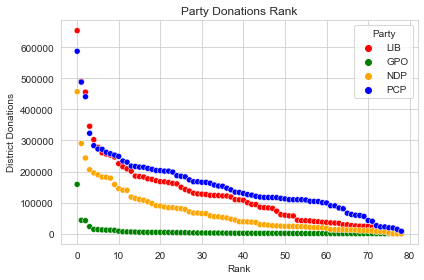

In [11]:
libdonations = complete.loc[complete['Party']=='LIB']['District Donations'].sort_values(ascending = False).reset_index(drop = True)
gpodonations = complete.loc[complete['Party']=='GPO']['District Donations'].sort_values(ascending = False).reset_index(drop = True)
ndpdonations = complete.loc[complete['Party']=='NDP']['District Donations'].sort_values(ascending = False).reset_index(drop = True)
pcpdonations = complete.loc[complete['Party']=='PCP']['District Donations'].sort_values(ascending = False).reset_index(drop = True)


descendingdonations = pd.DataFrame({'LIB':libdonations,'GPO':gpodonations,'NDP':ndpdonations,'PCP':pcpdonations}).fillna(0)
descendingdonations['Index']=descendingdonations.index
descendingdonations = descendingdonations.melt('Index', var_name='Party', value_name='District Donations')

sns.scatterplot(data = descendingdonations , x = 'Index', y = 'District Donations', hue = 'Party', palette = partypalette)
plt.xlabel('Rank')


sns.set_style("white")
plt.title('Party Donations Rank')
plt.tight_layout()
# plt.savefig('district donations rank.png')
plt.show()


Before continuing, we can visualize all of the variables to see if there are any interesting relationships to examine more closely.

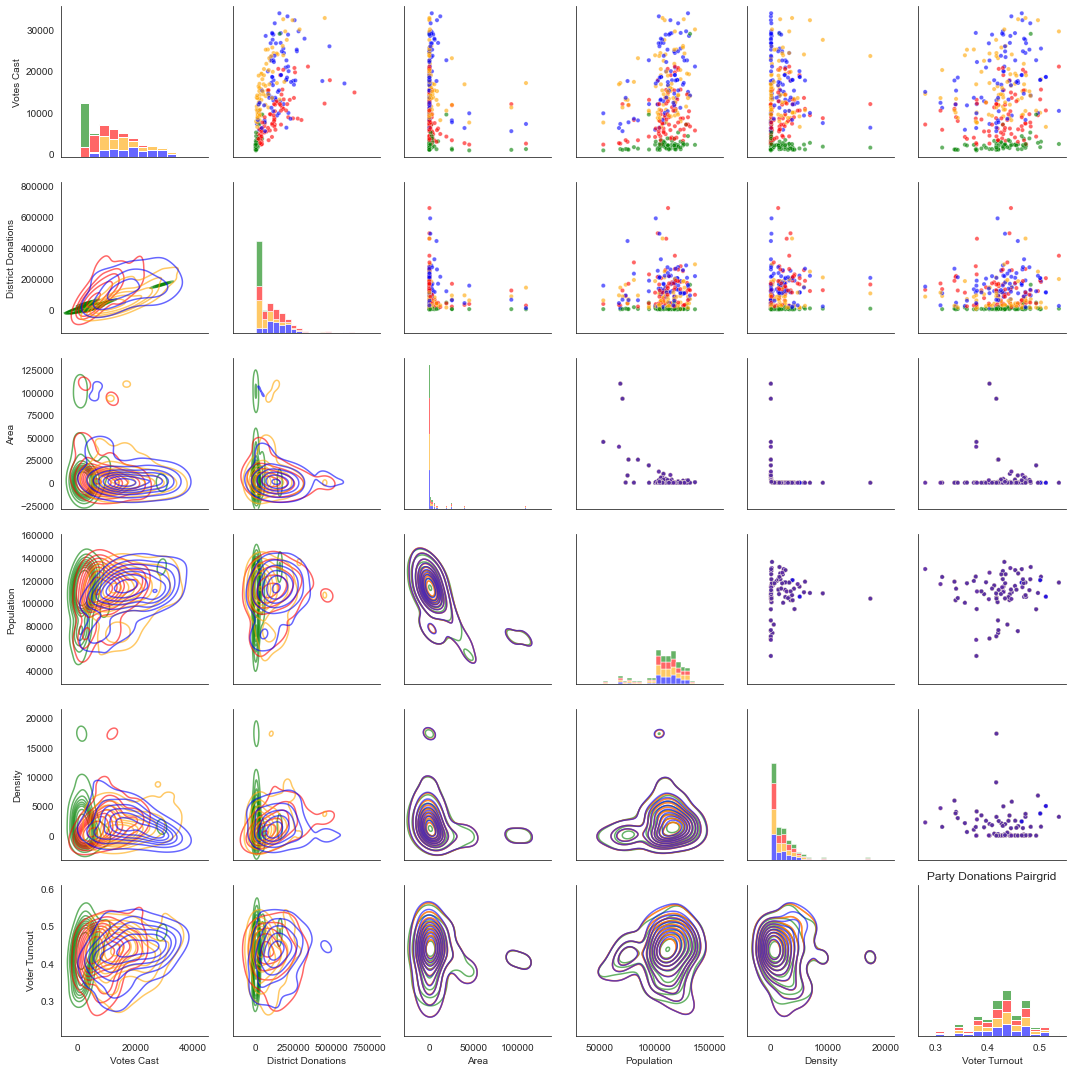

In [12]:
p = sns.PairGrid(data = complete.drop(columns = ['Winner','Winner 2011','Winner 2022','Votes Cast 2011','Votes Cast 2014','Winner 2014','Vote %','Total Party Donations']), hue = 'Party', palette = partypalette)
import warnings
warnings.filterwarnings('ignore')
p.map_upper(sns.scatterplot, alpha = 0.6, size = 2)
p.map_lower(sns.kdeplot, alpha = 0.6, size = 2)
p.map_diag(sns.histplot, multiple="stack", alpha = 0.6)

sns.set_style("white")
plt.title('Party Donations Pairgrid')
plt.tight_layout()
# plt.savefig('big pairgrid.png')
plt.show()


There are several relationships we can see above that we can examine in more detail. There appear to be some relationships relating Population, Density, and Voter Turnout, differing by party. If we look below, if the Votes Cast are compared to the Population, the population Density, and the Voter Turnout, we can see that the trends are similar for the NDP, the Liberals and the Green part, however the Conservatives seems to have recieved more votes for districts with higher populations, and higher voter turnouts, and much lower for denser districts. There is also an interesting feature shared by many of the graphs where the relationships seem to be bimodal.



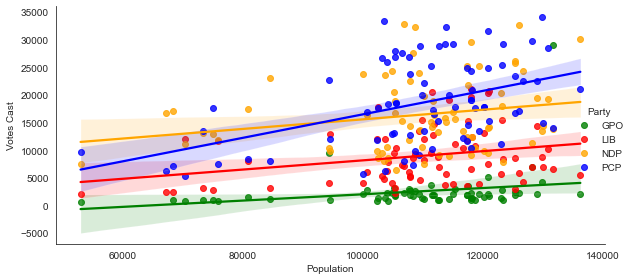

In [13]:
sns.lmplot(data = complete, x = 'Population', y = 'Votes Cast', hue = 'Party', palette = partypalette, height = 4, aspect = 2)

sns.set_style("whitegrid")
plt.tight_layout()
# plt.savefig('Visualizing Important Features.png')
plt.show()

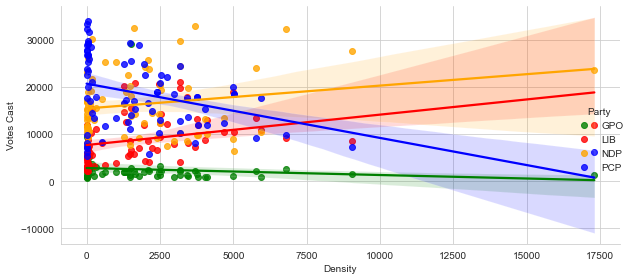

In [14]:
sns.lmplot(data = complete, x = 'Density', y = 'Votes Cast', hue = 'Party', palette = partypalette, height = 4, aspect = 2)

sns.set_style("whitegrid")
plt.tight_layout()
# plt.savefig('votes and density.png')
plt.show()

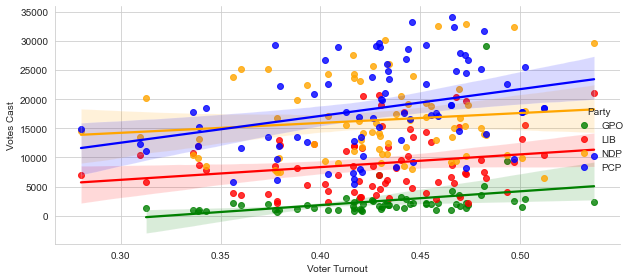

In [15]:
sns.lmplot(data = complete, x = 'Voter Turnout', y = 'Votes Cast', hue = 'Party', palette = partypalette, height = 4, aspect = 2)

sns.set_style("whitegrid")
plt.tight_layout()
# plt.savefig('votes and turnout.png')
plt.show()

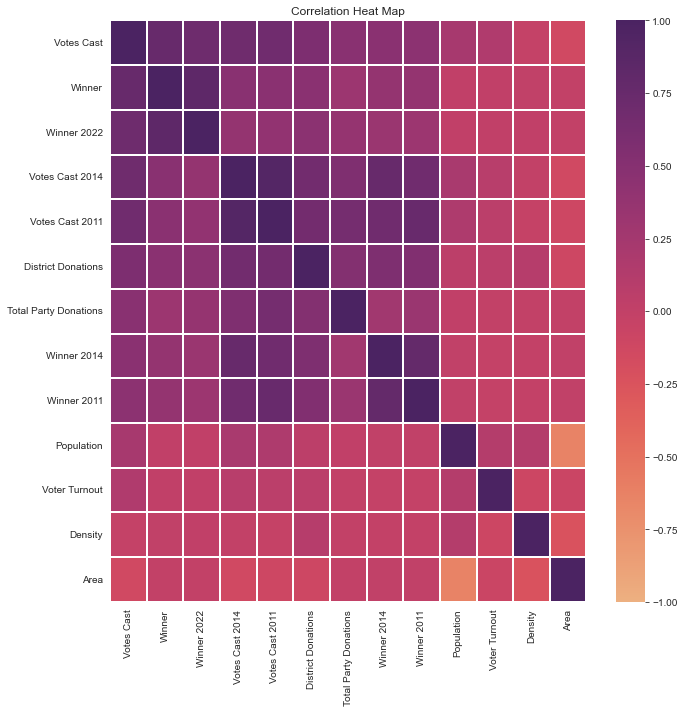

In [16]:
df = complete.drop(columns = ['Vote %'])

ix = df.corr().sort_values('Votes Cast', ascending=False).index
df_sorted = df.loc[:, ix]

plt.figure(figsize=(10,10))
sns.heatmap(df_sorted.corr(),linewidths=.1, annot=False, cmap = 'flare',vmin=-1, vmax=1)
plt.yticks(rotation=0);

plt.title('Correlation Heat Map')
plt.tight_layout()
# plt.savefig('Correlation heat map.png')
plt.show()

Next we can examine the correlations between variables, especially those most closely correlated with Votes Cast. The results of previous elections and the donations all have a positive corelation with the number of votes recieved by each candidate, whereas the variables related to the size, population, density and voter turnout have much weaker relationships. 






In [17]:
##############################################################################################################################
##############################################################################################################################









---

## Linear Regressions

The next thing to do is see if we can make a predictive model for the number of Votes Cast based on the information available. Since the main motivation was to analyze the relationship that financial donations have with electoral success, it makes sense to being with a plot comparing the Votes Cast to the District Donations, and to the Total Party Donations. The plot with District Donations suggest there is a positive correlation between the two variables for all parties, and a plot of the Votes Cast vs the Total Party Donations also suggests a positive relationship, although the sample size is very small.

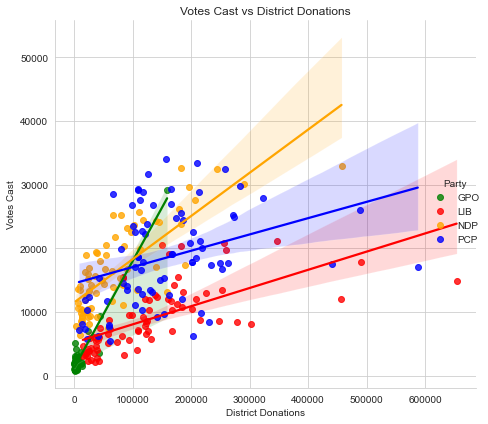

In [18]:
%matplotlib inline
sns.lmplot(data = complete, x = 'District Donations', y = 'Votes Cast', hue = 'Party', palette = partypalette, height=6, aspect=1)

sns.set_style("whitegrid")
plt.title('Votes Cast vs District Donations')
plt.tight_layout()
# plt.savefig('district donations regression.png')
plt.show()

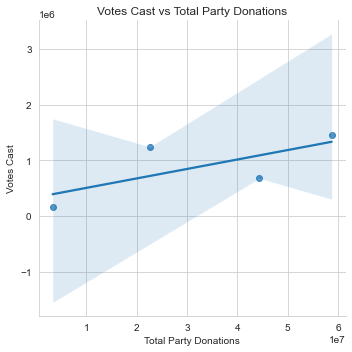

In [19]:
sns.lmplot(data = completegroups, y = 'Votes Cast', x = 'Total Party Donations')

plt.title('Votes Cast vs Total Party Donations')
plt.tight_layout()
# plt.savefig('total donations regression.png')
plt.show()

We can also saw in the Initial Analysis section that these appears to be a positive relationship between the votes in 2018 and in the previous years' elections, so it makes sense to examine those variables as well. First we can examine the correlations to see which variables may be suitable targets for a linear regression. It appears that the votes cast in previous elections, the donations, and the winning districts from the previous elections all have a moderate to strong correlation with the votes cast in 2018.

Now we can examine several linear regressions. If we use the donations, we obtain a significant model with a moderate R-squared, and small P for all coefficients, suggesting that donations do usefully account over a third of the observed variation in votes counts. The models using only District Donations or Total Party Donations alone do not provide as strong a relationship so they appear to be somewhat independent. If we closely examine a single variable regression using District Donations, we can see several issues with the regression. First, looking at the residuals vs the fitted values and the leverage, we can see that there is still a linear pattern. It is likely because their is another, unaccounted-for variable that is having an effect on the Votes Cast. We can also see from the QQ plot that the data is left-skewed. 

In [20]:
def linear_regression(df: DataFrame) -> DataFrame:
    """Perform a univariate regression and store results in a new data frame.

    Args:
        df (DataFrame): orginal data set with x and y.

    Returns:
        DataFrame: another dataframe with raw data and results.
    """
    mod = sm.OLS(endog=df['y'], exog=df['x']).fit()
    influence = mod.get_influence()

    res = df.copy()
    res['resid'] = mod.resid
    res['fittedvalues'] = mod.fittedvalues
    res['resid_std'] = mod.resid_pearson
    res['leverage'] = influence.hat_matrix_diag
    return res


def plot_diagnosis(df: DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.style.use('seaborn')
    sns.set_style("darkgrid")
    # Residual against fitted values.
    df.plot.scatter(
        x='fittedvalues', y='resid', ax=axes[0, 0]
    )
    axes[0, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qqplot
    sm.qqplot(
        df['resid'], dist=stats.t, fit=True, line='45',
        ax=axes[0, 1], c='#4C72B0'
    )
    axes[0, 1].set_title('Normal Q-Q')

    # The scale-location plot.
    df.plot.scatter(
        x='fittedvalues', y='resid_std', ax=axes[1, 0]
    )
    axes[1, 0].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 0].set_xlabel('Fitted values')
    axes[1, 0].set_ylabel('Standardized Residuals')
    axes[1, 0].set_title('Scale-Location')

    # Standardized residuals vs. leverage
    df.plot.scatter(
        x='leverage', y='resid_std', ax=axes[1, 1]
    )
    axes[1, 1].axhline(y=0, color='grey', linestyle='dashed')
    axes[1, 1].set_xlabel('Leverage')
    axes[1, 1].set_ylabel('Standardized Residuals')
    axes[1, 1].set_title('Residuals vs Leverage')

    plt.tight_layout()
    plt.show()

In [21]:
x = sm.add_constant(complete['District Donations'])
y = complete['Votes Cast']

x -= np.average(x)
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()

# model.summary()

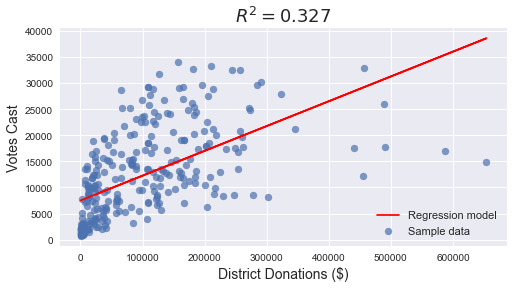

In [42]:
X = complete['District Donations'].values.reshape(-1,1)
y = complete['Votes Cast'].values


ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)


r2 = model.score(X, y)


fig, axs = plt.subplots(1, 1, figsize=(8, 4))

axs.plot(X, response, color='red', label='Regression model')
axs.scatter(X, y, alpha=0.7, label='Sample data')
axs.set_ylabel('Votes Cast', fontsize=14)
axs.set_xlabel('District Donations ($)', fontsize=14)
axs.legend(facecolor='white', fontsize=11)
axs.set_title('$R^2= %.3f$' % r2, fontsize=18)
plt.show()

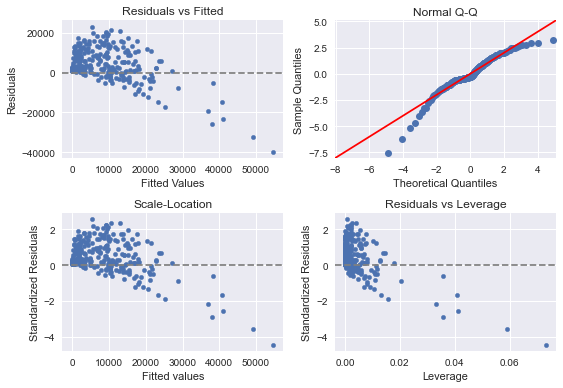

In [43]:
x = complete['District Donations']
y = complete['Votes Cast']

df = pd.DataFrame({'x':x,'y':y})

plot_diagnosis(linear_regression(df))

Regressions that use votes from previous elections work even better, which isn't too surprising. In this case however there are significant multicollinearity issues when using the results from both previous elections, so using only the votes from 2014 provides the best model. In this case, the QQ plot hsows the data is fairly normal, however the residuals show clearly that the data is heteroscedastic, with higher variance at high donation levels.

In [24]:
x = sm.add_constant(complete['Votes Cast 2014'])
y = complete['Votes Cast']

x -= np.average(x)
X = sm.add_constant(x)

model = sm.OLS(y, X).fit()

# model.summary()

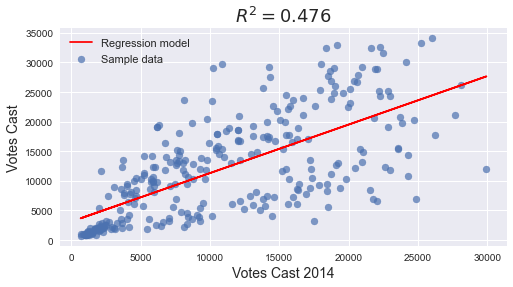

In [25]:
X = complete['Votes Cast 2014'].values.reshape(-1,1)
y = complete['Votes Cast'].values


ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)


r2 = model.score(X, y)


fig, axs = plt.subplots(1, 1, figsize=(8, 4))
axs.plot(X, response, color='red', label='Regression model')
axs.scatter(X, y, alpha=0.7, label='Sample data')
axs.set_ylabel('Votes Cast', fontsize=14)
axs.set_xlabel('Votes Cast 2014', fontsize=14)
axs.legend(facecolor='white', fontsize=11)
axs.set_title('$R^2= %.3f$' % r2, fontsize=18)

plt.show()

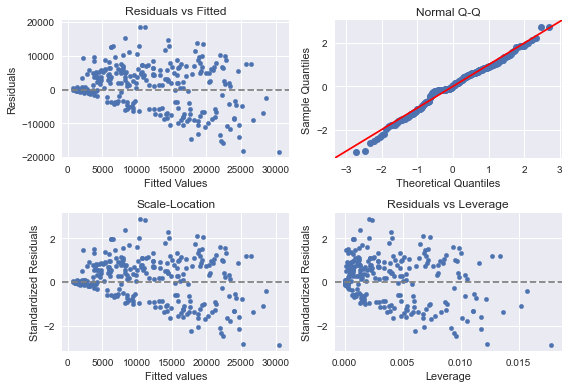

In [26]:
x = complete['Votes Cast 2014']
y = complete['Votes Cast']

df = pd.DataFrame({'x':x,'y':y})

plot_diagnosis(linear_regression(df))

In [27]:
completedummies = pd.concat([complete, pd.get_dummies(complete.Party)], axis=1, join="inner")

In [28]:
# completedummies.head(10)

In [29]:
##############################################################################################################################
##############################################################################################################################

---

## Machine Learning Predictions

#### K-Nearest Neighbour

Below we use a nearest neighbour and random forest machine learning model to create a predictive model. We are trying to take each candidate, and based on the data available, create a model that will predict whether that candidate will win their riding or not. The first model used is a k-nearest neighbours model, and several different k values are used to determine if their is an ideal k to use to provide the most accurate model. In the end result, the best model produces an accuracy of approximately 85%.

In [30]:
np.random.seed(123)
st = np.random.get_state()
np.random.set_state(st)

df_data = completedummies[['LIB', 'NDP', 'PCP', 'GPO', 'District Donations',
       'Votes Cast 2014', 'Winner 2014', 'Votes Cast 2011', 'Winner 2011', 'Total Party Donations']]

df_target = completedummies['Winner']

In [31]:
finalk = [1, 3, 5, 7, 10, 20, 30]
finalacc = []
finalnum = []

for k in finalk:

    acc_for_k = []
    num = []

    for i in range(0,100):

        X_train, X_test, y_train, y_test = train_test_split(df_data, df_target)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train.values.ravel())
        y_pred = knn.predict(X_test)
        num.append((y_pred == np.array(y_test)).sum())
        acc_for_k.append((y_pred == np.array(y_test)).sum()/y_pred.size)


    finalacc.append(np.array(acc_for_k).mean())

plotframe = pd.DataFrame({'k':finalk,'Accuracy':finalacc})
plotframe

,k,Accuracy
0,1,0.842027
1,3,0.859595
2,5,0.850676
3,7,0.851081
4,10,0.847838
5,20,0.846081
6,30,0.830676


#### Random Forest

The next model used is a random forest model. Several different number of estimators are used, the more estimators typically will return better results. This model performed better than the knn model with an accuracy closer to 89% with a larger number of estimators.

In [32]:
finaln = [10, 100, 250]
finalacc = []
finalnum = []

for n in finaln:

    acc_for_n = []
    num = []

    for i in range(0,100):

        rf = RandomForestClassifier(n_estimators=n)
        X_train, X_test, y_train, y_test = train_test_split(df_data, df_target)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        num.append((y_pred == np.array(y_test)).sum())
        acc_for_n.append((y_pred == np.array(y_test)).sum()/y_pred.size)


    finalacc.append(np.array(acc_for_n).mean())

plotframe = pd.DataFrame({'n':finaln,'Accuracy':finalacc})
plotframe

,n,Accuracy
0,10,0.879324
1,100,0.888784
2,250,0.890135


Using the better random forest model, we can do k-fold cross validation in order to test if the model might be effective on new data. The validation returned a similar accuracy around 89%

In [33]:
#
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
#
# Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
#

X_train, X_test, y_train, y_test = train_test_split(df_data, df_target)
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
ks = []


for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    ks.append(k+1)    
    
foldframe = pd.DataFrame({'Fold':ks,'Accuracy':scores})
foldframe

,Fold,Accuracy
0,1,0.954545
1,2,0.954545
2,3,0.863636
3,4,0.818182
4,5,0.818182
5,6,0.863636
6,7,0.863636
7,8,0.954545
8,9,0.909091
9,10,0.954545


In [34]:
# 'Cross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores))

In [35]:
pd.DataFrame({'Cross-Validation Accuracy':np.mean(scores),'Standard Deviation':np.std(scores)}, index = [0])

,Cross-Validation Accuracy,Standard Deviation
0,0.895455,0.053974


Finally, the model can be tested on a completely new set of data: the results of the 2022 election. using the model on these data provided an even higher 91% accuracy, suggesting the model may be effective even with completely new data.

In [36]:
df_data = completedummies[['LIB', 'NDP', 'PCP', 'GPO', 'District Donations',
       'Votes Cast 2014', 'Winner 2014', 'Votes Cast 2011', 'Winner 2011', 'Total Party Donations']]

df_target18 = completedummies['Winner']
df_target22 = completedummies['Winner 2022']

finaln = [10, 100, 250]
finalacc = []
finalnum = []

for n in finaln:

    acc_for_n = []
    num = []

    for i in range(0,100):

        rf = RandomForestClassifier(n_estimators=n)
        X_train18, X_test18, y_train18, y_test18 = train_test_split(df_data, df_target18)
        rf.fit(X_train18,y_train18)
        X_train22, X_test22, y_train22, y_test22 = train_test_split(df_data, df_target22)
        y_pred = rf.predict(X_test22)        
        acc_for_n.append((y_pred == np.array(y_test22)).sum()/y_pred.size)


    finalacc.append(np.array(acc_for_n).mean())

plotframe = pd.DataFrame({'n':finaln,'Accuracy':finalacc})
plotframe

,n,Accuracy
0,10,0.905676
1,100,0.911351
2,250,0.913378


Lastly, we can examine the importances of the different variables according to the model. Most interestingly, the District Donations is the variable with the highest importance.

In [37]:
df_data = completedummies[['LIB', 'NDP', 'PCP', 'GPO', 'District Donations',
       'Votes Cast 2014', 'Winner 2014', 'Votes Cast 2011', 'Winner 2011', 'Total Party Donations']]

df_target = completedummies['Winner']

X_train, X_test, y_train, y_test = train_test_split(df_data,df_target,test_size=0.2)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
feature_imp = pd.Series(rf.feature_importances_, index=['LIB', 'NDP', 'PCP', 'GPO', 'District Donations',
       'Votes Cast 2014', 'Winner 2014', 'Votes Cast 2011', 'Winner 2011', 'Total Party Donations']).sort_values(ascending=False)


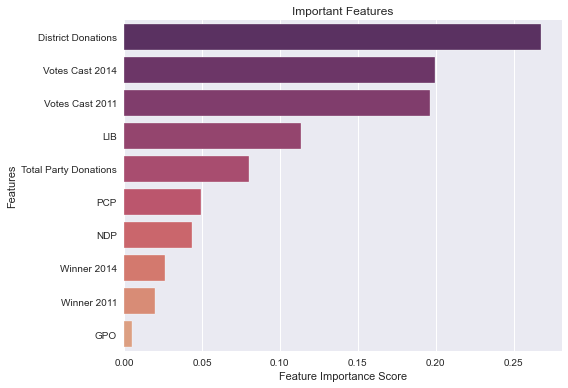

In [38]:
sns.barplot(x=feature_imp, y=feature_imp.index, palette = sns.color_palette("flare_r", 10))

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")

plt.tight_layout()
plt.savefig('Visualizing Important Features.png')

plt.show()

---

## Conclusions

There does appear to be a relationship between donations and election outcomes. We have seen that parties that recieve a larger  total amount of financial donations tend to win more seats in an election, and also that candidates that recieve more donations are more likely to win their riding. A linear regression to predict the number of votes that a candidate will recieve, based on the donations they recieve, accounts for slightly more than a third of the variation in the number of votes recieved. Similarly, in an effective machine learning model that predicts winning candidates with approximately 90% accuracy, the most important feature is the donations that the candidate recieved. 

## Appendix

Examples of the data frames used for analysis are shown below.

The first prepared data set has each row as one of the major political parties, and a variety of attributes related to that party, their financial donations and their electoral results.

In [39]:
completegroups.head(5)

,Votes Cast,Winner,Total Party Donations,Votes Cast 2014,Winner 2014,Votes Cast 2011,Winner 2011,Vote %,Winner 2022
Party,,,,,,,,,
GPO,158184.0,1.0,3296726.92,148313.0,0.0,76467.0,0.0,3.173885,1.0
LIB,677660.0,6.0,44351026.06,1225996.0,39.0,1099295.0,38.0,14.564344,7.0
NDP,1244682.0,27.0,22617023.03,812789.0,17.0,700620.0,13.0,27.404930,22.0
PCP,1458137.0,45.0,58720546.33,1010616.0,20.0,1012849.0,25.0,30.856840,48.0


In the second prepared data set, each row is an electoral district, and the columns are the donations for each major political party.

In [40]:
partydonations.head(5)

,District,GPO Donations,LIB Donations,NDP Donations,PCP Donations
0,Algoma Manitoulin,200.00,24228.00,140030.03,7863.00
1,Beaches East York,11456.09,252929.30,144667.45,141033.34
2,Bruce Grey Owen Sound,5618.00,41521.00,19125.00,165078.66
3,Burlington,1640.00,176591.40,43830.15,182884.54
4,Cambridge,1000.00,174796.01,35807.17,117852.38


The third data set is the one that is involved in most of the analysis. Each row represents one candidate for the election.

In [41]:
complete.head(5)

,District,Party,Votes Cast,Winner,District Donations,Votes Cast 2014,Winner 2014,Votes Cast 2011,Winner 2011,Vote %,Winner 2022,Total Party Donations,Area,Population,Density,Voter Turnout
0,Algoma Manitoulin,GPO,1025.0,0.0,200.00,828.0,0.0,684.0,0.0,0.037087,0.0,3296726.92,109575,68480,0.624960,0.403592
1,Algoma Manitoulin,LIB,2365.0,0.0,24228.00,6504.0,0.0,7397.0,0.0,0.085571,0.0,44351026.06,109575,68480,0.624960,0.403592
2,Algoma Manitoulin,NDP,17105.0,1.0,140030.03,14171.0,1.0,11585.0,1.0,0.618894,1.0,22617023.03,109575,68480,0.624960,0.403592
3,Algoma Manitoulin,PCP,7143.0,0.0,7863.00,4589.0,0.0,6141.0,0.0,0.258449,0.0,58720546.33,109575,68480,0.624960,0.403592
4,Beaches East York,GPO,2128.0,0.0,11456.09,2329.0,0.0,1025.0,0.0,0.043541,0.0,3296726.92,19,109465,5761.315789,0.446481
